In [455]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import all required libraries and modules

In [456]:

import os 
import sys
import shap
import optuna
from dotenv import load_dotenv
from scipy.stats import shapiro, norm, mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sys.path.append("/Users/nikolaynechay/Iris-Species")
sys.path.append("/home/nikolay/Deloitte/project_task/Iris")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

load_dotenv()

True

In [457]:
from src.core.helpers.model_evaluation import evaluate_model
from src.core.helpers.error_analysis import create_detailed_analysis, analyze_classification_errors_simple
from src.core.helpers.ea_hist_by_target import plot_error_distribution
from src.core.helpers.visualizations import plot_distributions_of_feature_by_classes, plot_boxplot_with_missclassifications
from src.core.helpers.feature_engineering import generate_new_features
from src.core.helpers.optuna_objective import objective_for_logistic_regression

# Data Collection

### Setting required Global Variables

In [458]:
IRIS_PATH = os.getenv("IRIS_PATH", "src/core/datafiles/raw/Iris.csv")

### Load dataset

In [459]:
iris_df = pd.read_csv(IRIS_PATH)
iris_df.drop('Id', axis=1, inplace=True)  # Delete ID column
iris_df.iloc[:5]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Sampling Training and Testing Datasets

To ensure robust evaluation, the dataset was stratified and split into training and testing subsets.  
Stratification preserves the original class distribution

In [460]:

species_label_encoder = LabelEncoder()

iris_measurements = iris_df.drop('Species', axis=1)
species_labels = species_label_encoder.fit_transform(iris_df['Species'])

train_measurements, test_measurements, train_species_labels, test_species_labels = train_test_split(
    iris_measurements,
    species_labels,
    test_size=0.2,
    random_state=41,
    stratify=species_labels
)
train_measurements.iloc[:5]
target_dict = dict(zip(species_label_encoder.transform(species_label_encoder.classes_), species_label_encoder.classes_))
print(target_dict)


{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


The dataset was splitted into training and testing subsets. This prepares the data for model training and evaluation while ensuring that the class distribution is preserved, enabling a fair assessment of model performance.


# Baseline section

As a starting point, I will build a baseline model.  
This model will serve as a reference point for evaluating all future experiments and decisions.

The baseline model defines a minimum acceptable performance threshold.  
Any further improvements or changes to the modeling pipeline should demonstrate measurable gains over this baseline to be considered valid.

### Model building

The baseline model is a logistic regression classifier with the following configuration:

- **Regularization**: L2 (Ridge), to penalize large coefficients and reduce overfitting.
- **Optimization algorithm**: LBFGS
- **Max iterations**: 50, to ensure convergence within a reasonable time frame.

This model establishes the initial benchmark for evaluating future enhancements.

In [461]:
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: objective_for_logistic_regression(
#     trial=trial,
#     X_train=train_measurements,
#     y_train=train_species_labels,
#     X_test=test_measurements,
#     y_test=test_species_labels
# ), n_trials=50)

# best_params = study.best_params
# print(f'Best Hyperparameters: {best_params}')

# baseline_model = LogisticRegression(**best_params, random_state=41)
# baseline_model.fit(train_measurements, train_species_labels)

In [462]:
baseline_model = LogisticRegression(max_iter=50, random_state=42)
baseline_model.fit(train_measurements, train_species_labels)

baseline_train_df_with_predictions, baseline_train_accuracy, baseline_train_precision, baseline_train_recall, baseline_train_f1 = evaluate_model(train_measurements, train_species_labels, baseline_model)
baseline_test_df_with_predictions, baseline_test_accuracy, baseline_test_precision, baseline_test_recall, baseline_test_f1 = evaluate_model(test_measurements, test_species_labels, baseline_model)

print("Baseline model evaluation:")
print(f"Train Accuracy: {baseline_train_accuracy:.4f}")
print(f"Train Precision: {baseline_train_precision:.4f}")
print(f"Train Recall: {baseline_train_recall:.4f}")
print(f"Train F1: {baseline_train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {baseline_test_accuracy:.4f}")
print(f"Test Precision: {baseline_test_precision:.4f}")
print(f"Test Recall: {baseline_test_recall:.4f}")
print(f"Test F1: {baseline_test_f1:.4f}")

Baseline model evaluation:
Train Accuracy: 0.9750
Train Precision: 0.9752
Train Recall: 0.9750
Train F1: 0.9750
---------------------
Test Accuracy: 0.9333
Test Precision: 0.9333
Test Recall: 0.9333
Test F1: 0.9333


/home/nikolay/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Error Analysis

##### Distribution of correct and incorrect predictions on train set

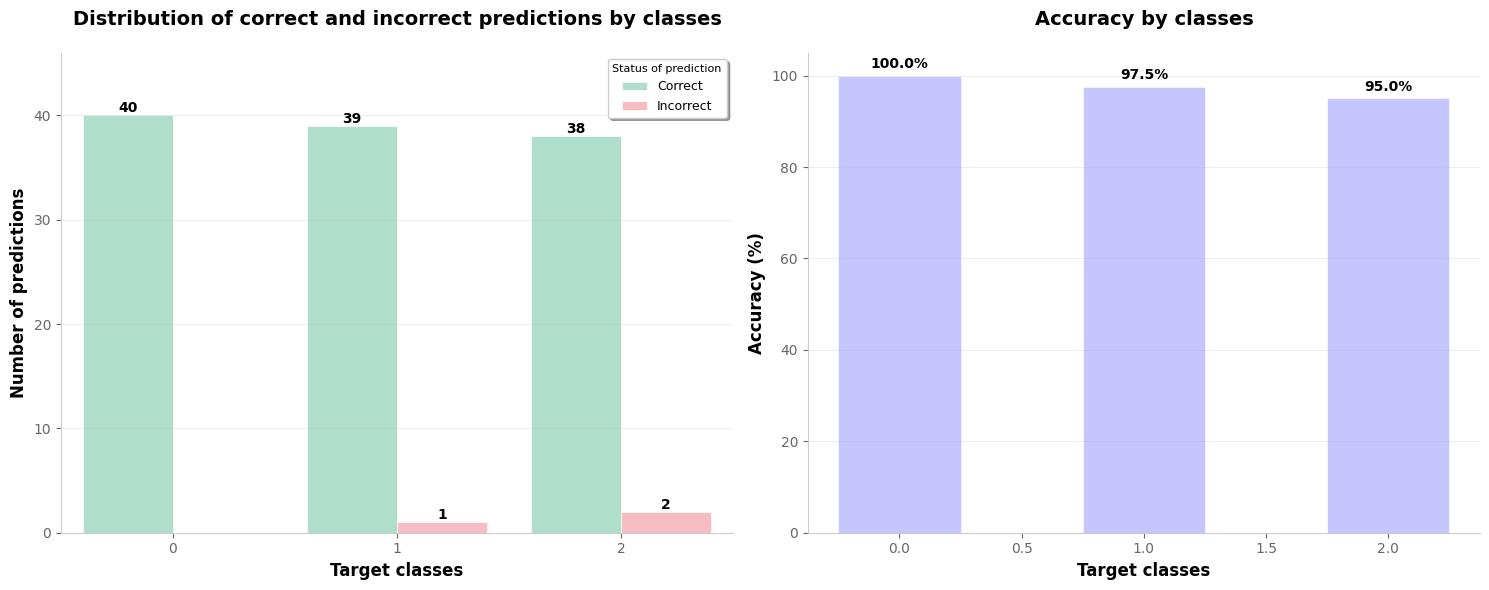

In [463]:
plot_error_distribution(baseline_train_df_with_predictions['predicted_label'], train_species_labels)

The model demonstrates high classification accuracy on the train set: 100% for class 0, 97.5% for class 1, and 95% for class 2. Potential issues: feature overlap with other classes.

##### Distribution of correct and incorrect predictions on test set

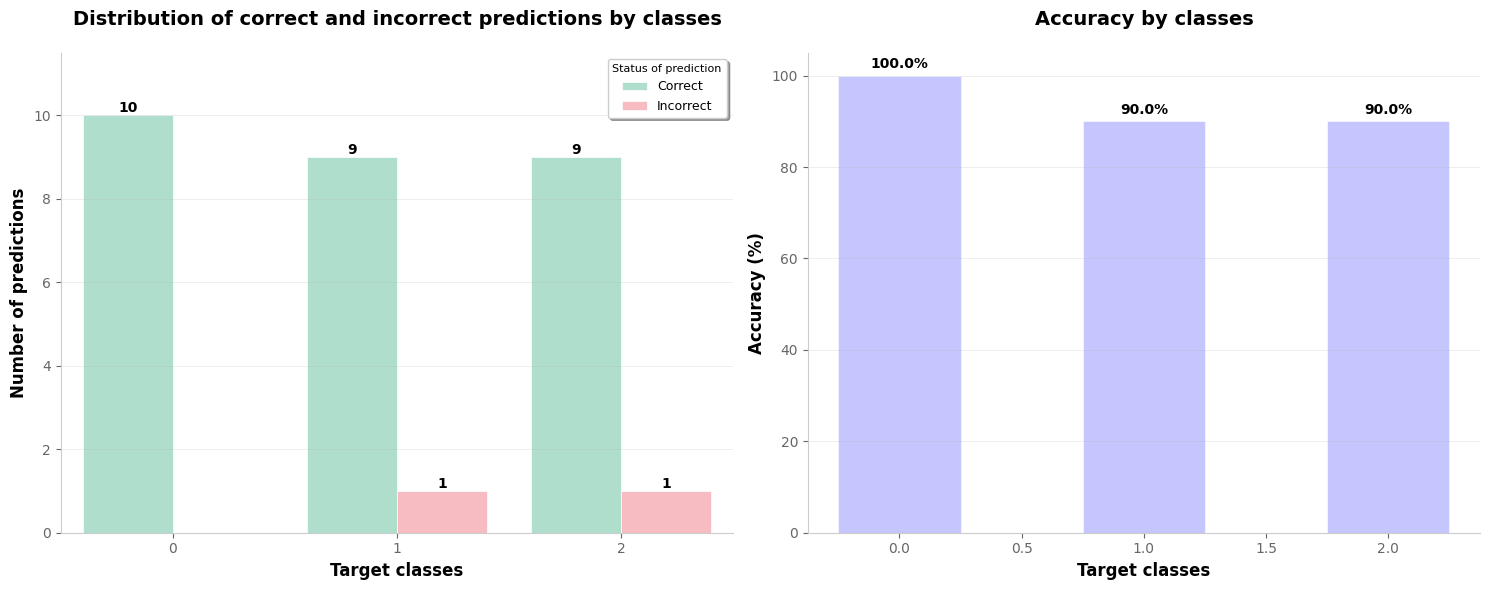

In [464]:
plot_error_distribution(baseline_test_df_with_predictions['predicted_label'], test_species_labels)

The model demonstrates high classification accuracy on test set: 100% for class 0, 90% for class 1, and 90% for class 2.

##### Create dataframe for error classifications on train set

In [465]:
baseline_train_df_errors = baseline_train_df_with_predictions[baseline_train_df_with_predictions['is_correct'] == False]
baseline_train_df_errors.iloc[:]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
106,4.9,2.5,4.5,1.7,2,1,0.004,0.562,0.434,False
83,6.0,2.7,5.1,1.6,1,2,0.001,0.420,0.579,False
119,6.0,2.2,5.0,1.5,2,1,0.001,0.600,0.399,False


##### Create dataframe for error classifications on test set

In [466]:
baseline_test_df_errors = baseline_test_df_with_predictions[baseline_test_df_with_predictions['is_correct'] == False]
baseline_test_df_errors.iloc[:]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
70,5.9,3.2,4.8,1.8,1,2,0.004,0.412,0.584,False
133,6.3,2.8,5.1,1.5,2,1,0.001,0.542,0.456,False


##### Extract weights and bias from baseline model

In [467]:
baseline_weights = baseline_model.coef_
baseline_bias = baseline_model.intercept_
baseline_feature_names = train_measurements.columns.tolist()

print(f"Baseline\nWeights: {baseline_weights}\nBias: {baseline_bias}")

Baseline
Weights: [[ 0.21367371  0.77728805 -2.45584691 -1.01756082]
 [ 0.25086047 -0.53925165 -0.11524461 -1.02615973]
 [-0.46453417 -0.2380364   2.57109153  2.04372055]]
Bias: [  6.63242277   4.0906008  -10.72302357]


##### Create detailed analysis dataframe by baseline model 

In [468]:
baseline_train_detailed_df = create_detailed_analysis(baseline_train_df_with_predictions, baseline_weights, baseline_bias, baseline_feature_names)
baseline_test_detailed_df = create_detailed_analysis(baseline_test_df_with_predictions, baseline_weights, baseline_bias, baseline_feature_names)
print(baseline_train_detailed_df.shape)
print(baseline_test_detailed_df.shape)
baseline_train_detailed_df.head()

(120, 45)
(30, 45)


,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,bias_diff
0,123,2,2,-3.788,0.002,6.632,1.803,0.454,4.091,1.985,0.544,-10.723,6.3,1.346,0.214,1.580,0.251,-2.927,-0.465,2.7,2.099,0.777,-1.456,-0.539,-0.643,-0.238,4.9,-12.034,-2.456,-0.565,-0.115,12.598,2.571,1.8,-1.832,-1.018,-1.847,-1.026,3.679,2.044,NaN,NaN,NaN,NaN,NaN
1,106,2,1,-3.159,0.004,6.632,1.709,0.562,4.091,1.450,0.434,-10.723,4.9,1.047,0.214,1.229,0.251,-2.276,-0.465,2.5,1.943,0.777,-1.348,-0.539,-0.595,-0.238,4.5,-11.051,-2.456,-0.519,-0.115,11.570,2.571,1.7,-1.730,-1.018,-1.744,-1.026,3.474,2.044,3.505,-0.753,-12.089,-5.219,14.814
2,149,2,2,-4.131,0.001,6.632,1.518,0.250,4.091,2.613,0.749,-10.723,5.9,1.261,0.214,1.480,0.251,-2.741,-0.465,3.0,2.332,0.777,-1.618,-0.539,-0.714,-0.238,5.1,-12.525,-2.456,-0.588,-0.115,13.113,2.571,1.8,-1.832,-1.018,-1.847,-1.026,3.679,2.044,NaN,NaN,NaN,NaN,NaN
3,10,0,0,6.775,0.976,6.632,3.072,0.024,4.091,-9.847,0.000,-10.723,5.4,1.154,0.214,1.355,0.251,-2.508,-0.465,3.7,2.876,0.777,-1.995,-0.539,-0.881,-0.238,1.5,-3.684,-2.456,-0.173,-0.115,3.857,2.571,0.2,-0.204,-1.018,-0.205,-1.026,0.409,2.044,NaN,NaN,NaN,NaN,NaN
4,98,1,1,1.179,0.203,6.632,2.547,0.796,4.091,-3.726,0.002,-10.723,5.1,1.090,0.214,1.279,0.251,-2.369,-0.465,2.5,1.943,0.777,-1.348,-0.539,-0.595,-0.238,3.0,-7.368,-2.456,-0.346,-0.115,7.713,2.571,1.1,-1.119,-1.018,-1.129,-1.026,2.248,2.044,NaN,NaN,NaN,NaN,NaN


##### Dataframe with missclassifications on train set

In [469]:
baseline_train_error_df = baseline_train_detailed_df[baseline_train_detailed_df['true_label'] != baseline_train_detailed_df['predicted_label']]
print(list(baseline_train_error_df.columns))
print(baseline_train_error_df.shape)
baseline_train_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,bias_diff
1,106,2,1,-3.159,0.004,6.632,1.709,0.562,4.091,1.450,0.434,-10.723,4.9,1.047,0.214,1.229,0.251,-2.276,-0.465,2.5,1.943,0.777,-1.348,-0.539,-0.595,-0.238,4.5,-11.051,-2.456,-0.519,-0.115,11.570,2.571,1.7,-1.730,-1.018,-1.744,-1.026,3.474,2.044,3.505,-0.753,-12.089,-5.219,14.814
10,83,1,2,-4.140,0.001,6.632,1.910,0.420,4.091,2.230,0.579,-10.723,6.0,1.282,0.214,1.505,0.251,-2.787,-0.465,2.7,2.099,0.777,-1.456,-0.539,-0.643,-0.238,5.1,-12.525,-2.456,-0.588,-0.115,13.113,2.571,1.6,-1.628,-1.018,-1.642,-1.026,3.270,2.044,-4.292,0.813,13.700,4.912,-14.814
113,119,2,1,-4.181,0.001,6.632,2.294,0.600,4.091,1.887,0.399,-10.723,6.0,1.282,0.214,1.505,0.251,-2.787,-0.465,2.2,1.710,0.777,-1.186,-0.539,-0.524,-0.238,5.0,-12.279,-2.456,-0.576,-0.115,12.855,2.571,1.5,-1.526,-1.018,-1.539,-1.026,3.066,2.044,4.292,-0.663,-13.432,-4.605,14.814


##### Dataframe with missclassifications on test set

In [470]:
baseline_test_error_df = baseline_test_detailed_df[baseline_test_detailed_df['true_label'] != baseline_test_detailed_df['predicted_label']]
print(list(baseline_test_error_df.columns))
print(baseline_test_error_df.shape)
baseline_test_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,bias_diff
7,70,1,2,-3.239,0.004,6.632,1.445,0.412,4.091,1.794,0.584,-10.723,5.9,1.261,0.214,1.48,0.251,-2.741,-0.465,3.2,2.487,0.777,-1.726,-0.539,-0.762,-0.238,4.8,-11.788,-2.456,-0.553,-0.115,12.341,2.571,1.8,-1.832,-1.018,-1.847,-1.026,3.679,2.044,-4.221,0.964,12.894,5.526,-14.814
19,133,2,1,-3.896,0.001,6.632,2.034,0.542,4.091,1.862,0.456,-10.723,6.3,1.346,0.214,1.58,0.251,-2.927,-0.465,2.8,2.176,0.777,-1.510,-0.539,-0.667,-0.238,5.1,-12.525,-2.456,-0.588,-0.115,13.113,2.571,1.5,-1.526,-1.018,-1.539,-1.026,3.066,2.044,4.507,-0.843,-13.700,-4.605,14.814


##### Train error analysis 

At this stage, I am analyzing the feature contributions, weights, and values that had the most significant impact on the incorrect predictions.

In [471]:
results = analyze_classification_errors_simple(
    df=baseline_train_error_df,
    feature_names=train_measurements.columns.tolist()
)

Analyse classification errors
Number of errors: 3

ERROR #1 (ID: 106.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.50, contribution=-12.089 
  PetalWidthCm   : value=1.70, contribution=-5.219 
  SepalLengthCm  : value=4.90, contribution=3.505 
  SepalWidthCm   : value=2.50, contribution=-0.753 
Main impact: PetalLengthCm (contribution: -12.089)

ERROR #2 (ID: 83.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=13.700 
  PetalWidthCm   : value=1.60, contribution=4.912 
  SepalLengthCm  : value=6.00, contribution=-4.292 
  SepalWidthCm   : value=2.70, contribution=0.813 
Main impact: PetalLengthCm (contribution: 13.700)

ERROR #3 (ID: 119.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.00, contribution=-13.432 
  PetalWidthCm   : value=1.50, contribution=-4.605 
  SepalLengthCm  : value=6.00, 

The misclassifications were primarily driven by the feature `PetalLengthCm`, which had the highest contribution in all errors, either positively or negatively. This suggests the model is overly reliant on this feature, causing confusion between classes 1 and 2.

##### Test error analysis 

In [472]:
results = analyze_classification_errors_simple(
    df=baseline_test_error_df,
    feature_names=test_measurements.columns.tolist()
)

Analyse classification errors
Number of errors: 2

ERROR #1 (ID: 70.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.80, contribution=12.894 
  PetalWidthCm   : value=1.80, contribution=5.526 
  SepalLengthCm  : value=5.90, contribution=-4.221 
  SepalWidthCm   : value=3.20, contribution=0.964 
Main impact: PetalLengthCm (contribution: 12.894)

ERROR #2 (ID: 133.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=-13.700 
  PetalWidthCm   : value=1.50, contribution=-4.605 
  SepalLengthCm  : value=6.30, contribution=4.507 
  SepalWidthCm   : value=2.80, contribution=-0.843 
Main impact: PetalLengthCm (contribution: -13.700)


SUMMARY TABLE OF ERRORS:
----------------------------------------------------------------------
Error    ID    True       Predicted     Main impact     Contribution
---------------------------------------------------------------------

The model exhibits systematic bias in handling PetalLengthCm on train and test sets, which dominates prediction behavior. To improve robustness:

- Consider engineering additional features that decouple this dependency.
- Further investigate of PetalLengthCm feature 

# Working section

This section focuses on developing and testing enhanced models based on insights derived from the baseline model's error analysis.
The objective is to iteratively refine the solution by addressing the identified weaknesses, applying feature engineering, tuning hyperparameters, and experimenting with more advanced algorithms to boost overall performance.

### Feature Engineering 

During the error analysis of the baseline model, it was observed that in all misclassification cases, the model heavily relied on the PetalLengthCm feature, assigning it the highest importance. Additionally, the model needs to be robust to "mutant" inputs — atypical feature values.

To address this, a targeted feature engineering step was introduced. New features were created based on pairwise ratios and interactions between the original features, enhancing the model’s ability to capture non-linear relationships and improve robustness to unusual inputs. From this extended feature set, only those that demonstrated strong class separability were retained. Finally, the top-k most informative features were selected to train the same linear model, aiming for improved generalization and classification performance.

In [473]:
# New feature set
generated_train_measurements, generated_train_species_labels = generate_new_features(
    X=train_measurements,
    y=train_species_labels,
)

generated_test_measurements, generated_test_species_labels = generate_new_features(
    X=test_measurements,
    y=test_species_labels
)

New features have been successfully generated, combning original features with pairwise ratios.

### Model building

Current working model is a logistic regression classifier with the following configuration:

- **Regularization**: L2 (Ridge), to penalize large coefficients and reduce overfitting.
- **Optimization algorithm**: LBFGS
- **Max iterations**: 50, to ensure convergence within a reasonable time frame.

In [474]:
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: objective_for_logistic_regression(
#     trial=trial,
#     X_train=generated_train_measurements,
#     y_train=generated_train_species_labels,
#     X_test=generated_test_measurements,
#     y_test=generated_test_species_labels
# ), n_trials=50)

# best_params = study.best_params
# print(f'Best Hyperparameters: {best_params}')

# working_model = LogisticRegression(**best_params, random_state=41)
# working_model.fit(generated_train_measurements, generated_train_species_labels)

In [475]:
working_model = LogisticRegression(max_iter=50, random_state=41)
working_model.fit(generated_train_measurements, generated_train_species_labels)

working_train_df_with_predictions, working_train_accuracy, working_train_precision, working_train_recall, working_train_f1 = evaluate_model(generated_train_measurements, generated_train_species_labels, working_model)
working_test_df_with_predictions, working_test_accuracy, working_test_precision, working_test_recall, working_test_f1 = evaluate_model(generated_test_measurements, generated_test_species_labels, working_model)

print("Working model evaluation:")
print(f"Train Accuracy: {working_train_accuracy:.4f}")
print(f"Train Precision: {working_train_precision:.4f}")
print(f"Train Recall: {working_train_recall:.4f}")
print(f"Train F1: {working_train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {working_test_accuracy:.4f}")
print(f"Test Precision: {working_test_precision:.4f}")
print(f"Test Recall: {working_test_recall:.4f}")
print(f"Test F1: {working_test_f1:.4f}")

Working model evaluation:
Train Accuracy: 0.9750
Train Precision: 0.9752
Train Recall: 0.9750
Train F1: 0.9750
---------------------
Test Accuracy: 0.9000
Test Precision: 0.9024
Test Recall: 0.9000
Test F1: 0.8997


/home/nikolay/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [476]:
working_train_df_with_predictions.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,PetalRatio,SepalRatio,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
123,6.3,2.7,4.9,1.8,2.722222,2.333333,2,2,0.001,0.323,0.676,True
106,4.9,2.5,4.5,1.7,2.647059,1.960000,2,2,0.003,0.473,0.524,True
149,5.9,3.0,5.1,1.8,2.833333,1.966667,2,2,0.001,0.257,0.742,True
10,5.4,3.7,1.5,0.2,7.500000,1.459459,0,0,0.998,0.002,0.000,True
98,5.1,2.5,3.0,1.1,2.727273,2.040000,1,1,0.074,0.922,0.005,True


### Error Analysis

##### Distribution of correct and incorrect predictions on train set

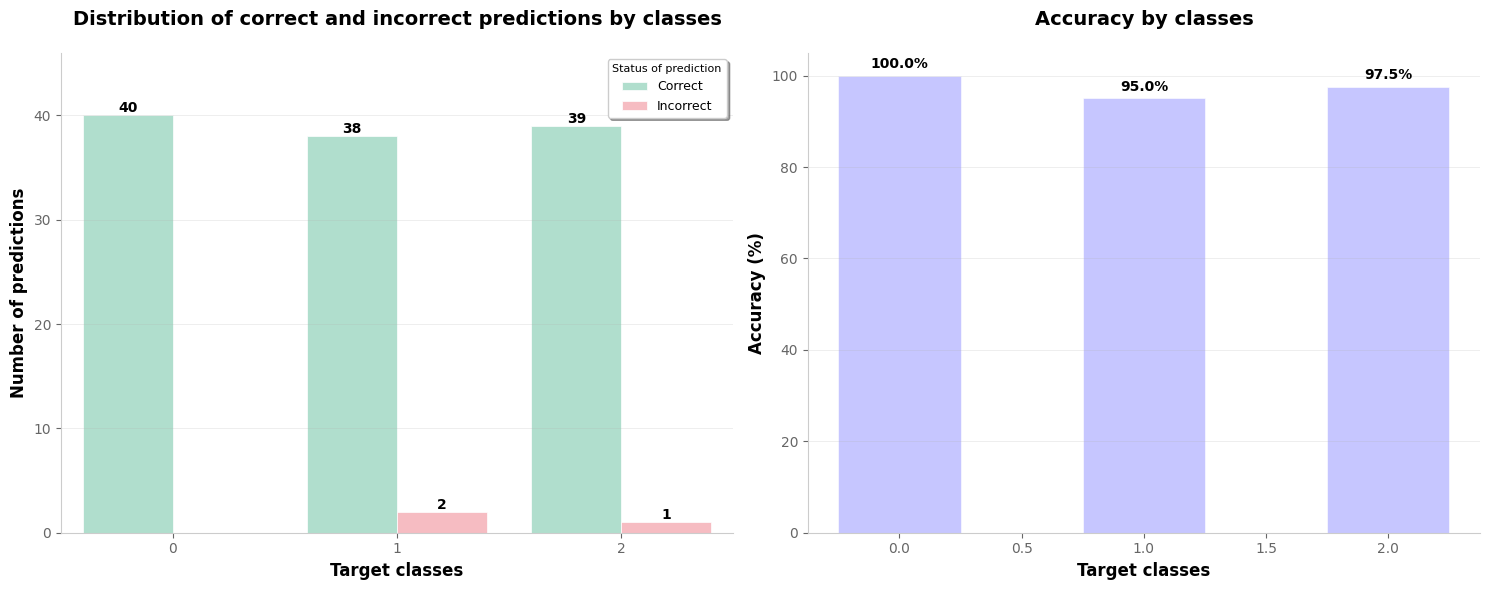

In [477]:
plot_error_distribution(working_train_df_with_predictions['predicted_label'], train_species_labels)


The model demonstrates high classification accuracy on the train set: 100% for class 0, 92.5% for class 1, and 92,5% for class 2. Potential issues: feature overlap with other classes.

##### Distribution of correct and incorrect predictions on test set

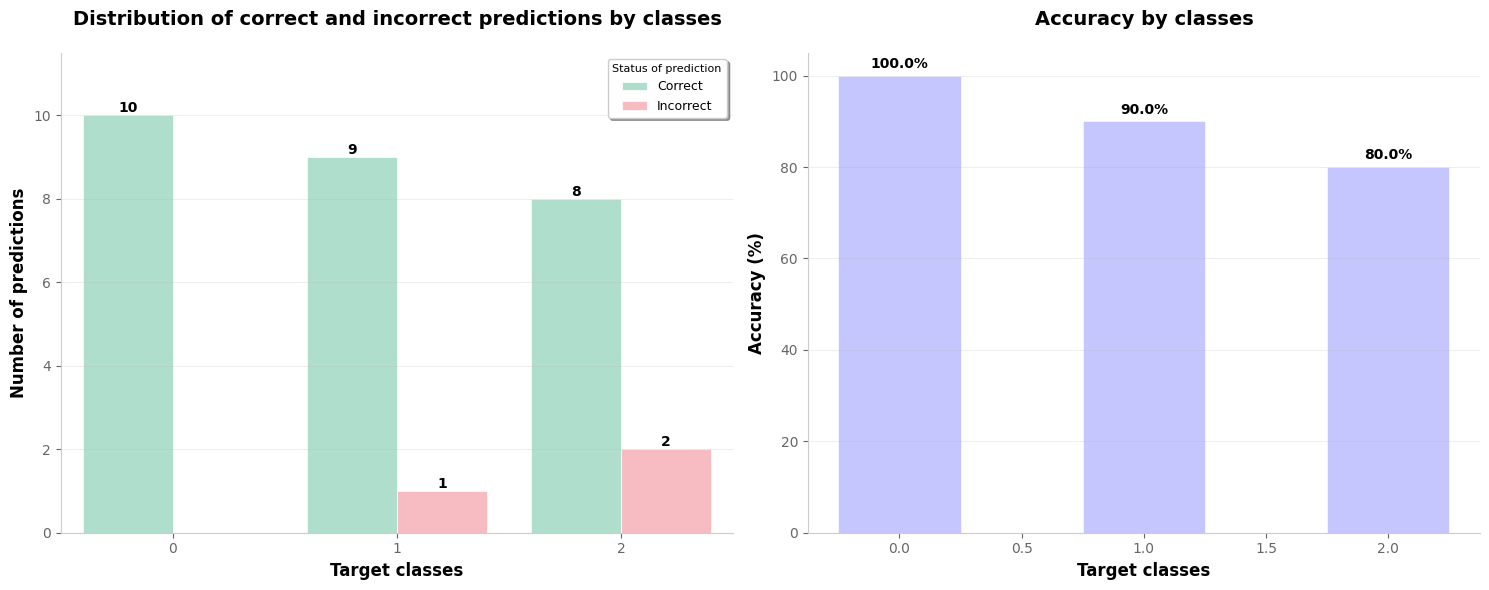

In [478]:
plot_error_distribution(working_test_df_with_predictions['predicted_label'], test_species_labels)

The model demonstrates high classification accuracy on test set: 100% for class 0, 100% for class 1, and 100% for class 2.

##### Create dataframe for error classifications on train set

In [479]:
working_train_df_errors = working_train_df_with_predictions[working_train_df_with_predictions['is_correct'] == False]
working_train_df_errors.iloc[:]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,PetalRatio,SepalRatio,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
83,6.0,2.7,5.1,1.6,3.187500,2.222222,1,2,0.001,0.487,0.512,False
77,6.7,3.0,5.0,1.7,2.941176,2.233333,1,2,0.001,0.462,0.537,False
119,6.0,2.2,5.0,1.5,3.333333,2.727273,2,1,0.001,0.624,0.375,False


##### Create dataframe for error classifications on test set

In [480]:
working_test_df_errors = working_test_df_with_predictions[working_test_df_with_predictions['is_correct'] == False]
working_test_df_errors.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,PetalRatio,SepalRatio,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
134,6.1,2.6,5.6,1.4,4.000000,2.346154,2,1,0.001,0.628,0.371,False
70,5.9,3.2,4.8,1.8,2.666667,1.843750,1,2,0.002,0.370,0.628,False
133,6.3,2.8,5.1,1.5,3.400000,2.250000,2,1,0.002,0.659,0.339,False


##### Extract weights and bias from working model 

In [481]:
working_weights = working_model.coef_
working_bias = working_model.intercept_
working_feature_names = generated_train_measurements.columns.tolist()

print(f"Working\nWeights: {working_weights}\nBias: {working_bias}")

Working
Weights: [[-0.06424469  0.85455324 -2.02958314 -0.68968106  1.16504236 -0.3285746 ]
 [ 0.18081804 -0.26027583 -0.17944622 -1.02423738  0.17396323  0.15838915]
 [-0.11657334 -0.59427742  2.20902936  1.71391844 -1.33900559  0.17018545]]
Bias: [ 2.61691764  3.20575828 -5.82267592]


##### Create detailed analysis dataframe by working model 

In [482]:
working_train_detailed_df = create_detailed_analysis(working_train_df_with_predictions, working_weights, working_bias, working_feature_names)
working_test_detailed_df = create_detailed_analysis(working_test_df_with_predictions, working_weights, working_bias, working_feature_names)
working_train_detailed_df.head()

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,PetalRatio_value,PetalRatio_contribution_class_0,PetalRatio_weight_class_0,PetalRatio_contribution_class_1,PetalRatio_weight_class_1,PetalRatio_contribution_class_2,PetalRatio_weight_class_2,SepalRatio_value,SepalRatio_contribution_class_0,SepalRatio_weight_class_0,SepalRatio_contribution_class_1,SepalRatio_weight_class_1,SepalRatio_contribution_class_2,SepalRatio_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,contribution_diff_PetalRatio,contribution_diff_SepalRatio,bias_diff
0,123,2,2,-4.262,0.001,2.617,1.762,0.323,3.206,2.500,0.676,-5.823,6.3,-0.405,-0.064,1.139,0.181,-0.734,-0.117,2.7,2.307,0.855,-0.703,-0.26,-1.605,-0.594,4.9,-9.945,-2.03,-0.879,-0.179,10.824,2.209,1.8,-1.241,-0.69,-1.844,-1.024,3.085,1.714,2.722,3.172,1.165,0.474,0.174,-3.645,-1.339,2.333,-0.767,-0.329,0.370,0.158,0.397,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,106,2,2,-3.427,0.003,2.617,1.663,0.473,3.206,1.764,0.524,-5.823,4.9,-0.315,-0.064,0.886,0.181,-0.571,-0.117,2.5,2.136,0.855,-0.651,-0.26,-1.486,-0.594,4.5,-9.133,-2.03,-0.808,-0.179,9.941,2.209,1.7,-1.172,-0.69,-1.741,-1.024,2.914,1.714,2.647,3.084,1.165,0.460,0.174,-3.544,-1.339,1.960,-0.644,-0.329,0.310,0.158,0.334,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,149,2,2,-4.136,0.001,2.617,1.537,0.257,3.206,2.599,0.742,-5.823,5.9,-0.379,-0.064,1.067,0.181,-0.688,-0.117,3.0,2.564,0.855,-0.781,-0.26,-1.783,-0.594,5.1,-10.351,-2.03,-0.915,-0.179,11.266,2.209,1.8,-1.241,-0.69,-1.844,-1.024,3.085,1.714,2.833,3.301,1.165,0.493,0.174,-3.794,-1.339,1.967,-0.646,-0.329,0.311,0.158,0.335,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,0,0,10.508,0.998,2.617,4.281,0.002,3.206,-14.789,0.000,-5.823,5.4,-0.347,-0.064,0.976,0.181,-0.629,-0.117,3.7,3.162,0.855,-0.963,-0.26,-2.199,-0.594,1.5,-3.044,-2.03,-0.269,-0.179,3.314,2.209,0.2,-0.138,-0.69,-0.205,-1.024,0.343,1.714,7.500,8.738,1.165,1.305,0.174,-10.043,-1.339,1.459,-0.480,-0.329,0.231,0.158,0.248,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98,1,1,0.085,0.074,2.617,2.610,0.922,3.206,-2.695,0.005,-5.823,5.1,-0.328,-0.064,0.922,0.181,-0.595,-0.117,2.5,2.136,0.855,-0.651,-0.26,-1.486,-0.594,3.0,-6.089,-2.03,-0.538,-0.179,6.627,2.209,1.1,-0.759,-0.69,-1.127,-1.024,1.885,1.714,2.727,3.177,1.165,0.474,0.174,-3.652,-1.339,2.040,-0.670,-0.329,0.323,0.158,0.347,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Dataframe with missclassifications on train set

In [483]:
working_train_error_df = working_train_detailed_df[working_train_detailed_df['true_label'] != working_train_detailed_df['predicted_label']]
print(list(working_train_error_df.columns))
print(working_train_error_df.shape)
working_train_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,PetalRatio_value,PetalRatio_contribution_class_0,PetalRatio_weight_class_0,PetalRatio_contribution_class_1,PetalRatio_weight_class_1,PetalRatio_contribution_class_2,PetalRatio_weight_class_2,SepalRatio_value,SepalRatio_contribution_class_0,SepalRatio_weight_class_0,SepalRatio_contribution_class_1,SepalRatio_weight_class_1,SepalRatio_contribution_class_2,SepalRatio_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,contribution_diff_PetalRatio,contribution_diff_SepalRatio,bias_diff
10,83,1,2,-3.932,0.001,2.617,1.940,0.487,3.206,1.992,0.512,-5.823,6.0,-0.385,-0.064,1.085,0.181,-0.699,-0.117,2.7,2.307,0.855,-0.703,-0.26,-1.605,-0.594,5.1,-10.351,-2.03,-0.915,-0.179,11.266,2.209,1.6,-1.103,-0.69,-1.639,-1.024,2.742,1.714,3.187,3.714,1.165,0.555,0.174,-4.268,-1.339,2.222,-0.730,-0.329,0.352,0.158,0.378,0.17,-1.784,-0.902,12.181,4.381,-4.823,0.026,-9.028
29,77,1,2,-3.877,0.001,2.617,1.863,0.462,3.206,2.014,0.537,-5.823,6.7,-0.430,-0.064,1.211,0.181,-0.781,-0.117,3.0,2.564,0.855,-0.781,-0.26,-1.783,-0.594,5.0,-10.148,-2.03,-0.897,-0.179,11.045,2.209,1.7,-1.172,-0.69,-1.741,-1.024,2.914,1.714,2.941,3.427,1.165,0.512,0.174,-3.938,-1.339,2.233,-0.734,-0.329,0.354,0.158,0.380,0.17,-1.993,-1.002,11.942,4.655,-4.450,0.026,-9.028
113,119,2,1,-4.084,0.001,2.617,2.296,0.624,3.206,1.787,0.375,-5.823,6.0,-0.385,-0.064,1.085,0.181,-0.699,-0.117,2.2,1.880,0.855,-0.573,-0.26,-1.307,-0.594,5.0,-10.148,-2.03,-0.897,-0.179,11.045,2.209,1.5,-1.035,-0.69,-1.536,-1.024,2.571,1.714,3.333,3.883,1.165,0.580,0.174,-4.463,-1.339,2.727,-0.896,-0.329,0.432,0.158,0.464,0.17,1.784,0.735,-11.942,-4.107,5.043,-0.032,9.028


##### Dataframe with missclassifications on test set

In [484]:
working_test_error_df = working_test_detailed_df[working_test_detailed_df['true_label'] != working_test_detailed_df['predicted_label']]
print(list(working_test_error_df.columns))
print(working_test_error_df.shape)
working_test_error_df.head()

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalLengthCm_value,PetalLengthCm_contribution_class_0,PetalLengthCm_weight_class_0,PetalLengthCm_contribution_class_1,PetalLengthCm_weight_class_1,PetalLengthCm_contribution_class_2,PetalLengthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,PetalRatio_value,PetalRatio_contribution_class_0,PetalRatio_weight_class_0,PetalRatio_contribution_class_1,PetalRatio_weight_class_1,PetalRatio_contribution_class_2,PetalRatio_weight_class_2,SepalRatio_value,SepalRatio_contribution_class_0,SepalRatio_weight_class_0,SepalRatio_contribution_class_1,SepalRatio_weight_class_1,SepalRatio_contribution_class_2,SepalRatio_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalLengthCm,contribution_diff_PetalWidthCm,contribution_diff_PetalRatio,contribution_diff_SepalRatio,bias_diff
5,134,2,1,-3.995,0.001,2.617,2.261,0.628,3.206,1.734,0.371,-5.823,6.1,-0.392,-0.064,1.103,0.181,-0.711,-0.117,2.6,2.222,0.855,-0.677,-0.26,-1.545,-0.594,5.6,-11.366,-2.03,-1.005,-0.179,12.371,2.209,1.4,-0.966,-0.69,-1.434,-1.024,2.399,1.714,4.000,4.660,1.165,0.696,0.174,-5.356,-1.339,2.346,-0.771,-0.329,0.372,0.158,0.399,0.17,1.814,0.868,-13.375,-3.833,6.052,-0.028,9.028
7,70,1,2,-3.510,0.002,2.617,1.491,0.370,3.206,2.019,0.628,-5.823,5.9,-0.379,-0.064,1.067,0.181,-0.688,-0.117,3.2,2.735,0.855,-0.833,-0.26,-1.902,-0.594,4.8,-9.742,-2.03,-0.861,-0.179,10.603,2.209,1.8,-1.241,-0.69,-1.844,-1.024,3.085,1.714,2.667,3.107,1.165,0.464,0.174,-3.571,-1.339,1.844,-0.606,-0.329,0.292,0.158,0.314,0.17,-1.755,-1.069,11.465,4.929,-4.035,0.022,-9.028
19,133,2,1,-3.559,0.002,2.617,2.112,0.659,3.206,1.446,0.339,-5.823,6.3,-0.405,-0.064,1.139,0.181,-0.734,-0.117,2.8,2.393,0.855,-0.729,-0.26,-1.664,-0.594,5.1,-10.351,-2.03,-0.915,-0.179,11.266,2.209,1.5,-1.035,-0.69,-1.536,-1.024,2.571,1.714,3.400,3.961,1.165,0.591,0.174,-4.553,-1.339,2.250,-0.739,-0.329,0.356,0.158,0.383,0.17,1.874,0.935,-12.181,-4.107,5.144,-0.027,9.028


##### Train error analysis

In [485]:
results = analyze_classification_errors_simple(
    df=working_train_error_df,
    feature_names=generated_train_measurements.columns.tolist()
)

Analyse classification errors
Number of errors: 3

ERROR #1 (ID: 83.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=12.181 
  PetalRatio     : value=3.19, contribution=-4.823 
  PetalWidthCm   : value=1.60, contribution=4.381 
  SepalLengthCm  : value=6.00, contribution=-1.784 
  SepalWidthCm   : value=2.70, contribution=-0.902 
  SepalRatio     : value=2.22, contribution=0.026 
Main impact: PetalLengthCm (contribution: 12.181)

ERROR #2 (ID: 77.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.00, contribution=11.942 
  PetalWidthCm   : value=1.70, contribution=4.655 
  PetalRatio     : value=2.94, contribution=-4.450 
  SepalLengthCm  : value=6.70, contribution=-1.993 
  SepalWidthCm   : value=3.00, contribution=-1.002 
  SepalRatio     : value=2.23, contribution=0.026 
Main impact: PetalLengthCm (contribution: 11.942)

ERROR #3 (ID: 119.0)
True class

All classification errors were driven by extreme contributions from `generated_PetalLengthCm` == `PetalLengthCm`, indicating the model's over-reliance on this single feature and the limited corrective effect of engineered ratios.

##### Test error analysis

In [486]:
results = analyze_classification_errors_simple(
    df=working_test_error_df,
    feature_names=generated_test_measurements.columns.tolist()
)

Analyse classification errors
Number of errors: 3

ERROR #1 (ID: 134.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.60, contribution=-13.375 
  PetalRatio     : value=4.00, contribution=6.052 
  PetalWidthCm   : value=1.40, contribution=-3.833 
  SepalLengthCm  : value=6.10, contribution=1.814 
  SepalWidthCm   : value=2.60, contribution=0.868 
  SepalRatio     : value=2.35, contribution=-0.028 
Main impact: PetalLengthCm (contribution: -13.375)

ERROR #2 (ID: 70.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.80, contribution=11.465 
  PetalWidthCm   : value=1.80, contribution=4.929 
  PetalRatio     : value=2.67, contribution=-4.035 
  SepalLengthCm  : value=5.90, contribution=-1.755 
  SepalWidthCm   : value=3.20, contribution=-1.069 
  SepalRatio     : value=1.84, contribution=0.022 
Main impact: PetalLengthCm (contribution: 11.465)

ERROR #3 (ID: 133.0)
True cla

Unfortunately, the applied approach did not yield the desired result; while adding new features based on pairwise relationships helped mitigate the impact of mutants, it did not reduce the dominance of the `PetalLengthCm` feature.


### EDA

##### Create 2 dataframes (train and test) which will contain original target and predicted labels

In [487]:
general_train_df_for_plot = working_train_detailed_df.copy()
general_test_df_for_plot = working_test_detailed_df.copy()

general_train_df_for_plot['true_label'] = general_train_df_for_plot['true_label'].map(target_dict)
general_train_df_for_plot['predicted_label'] = general_train_df_for_plot['predicted_label'].map(target_dict)
general_test_df_for_plot['true_label'] = general_test_df_for_plot['true_label'].map(target_dict)
general_test_df_for_plot['predicted_label'] = general_test_df_for_plot['predicted_label'].map(target_dict)


Visualize distributions of problematic feature (PetalLengthCm) by classes for train set

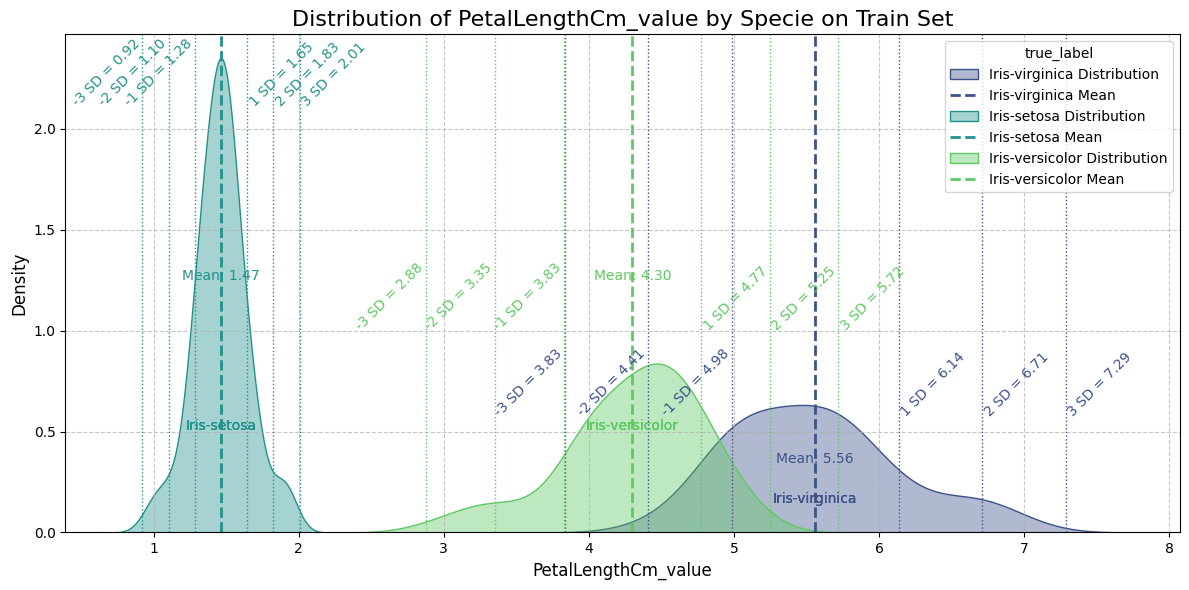

In [488]:
plot_distributions_of_feature_by_classes(
    general_df=general_train_df_for_plot,
    feature_name='PetalLengthCm_value',
    target_name='true_label', 
    flag='train'
)

The distributions of the problematic feature on train set indicate that the root of the problem lies in the overlapping of the two distributions (Versicolor and Virginica), starting from approximately ±1 standard deviation.


Visualize distributions of problematic feature (PetalLengthCm) by classes for test set

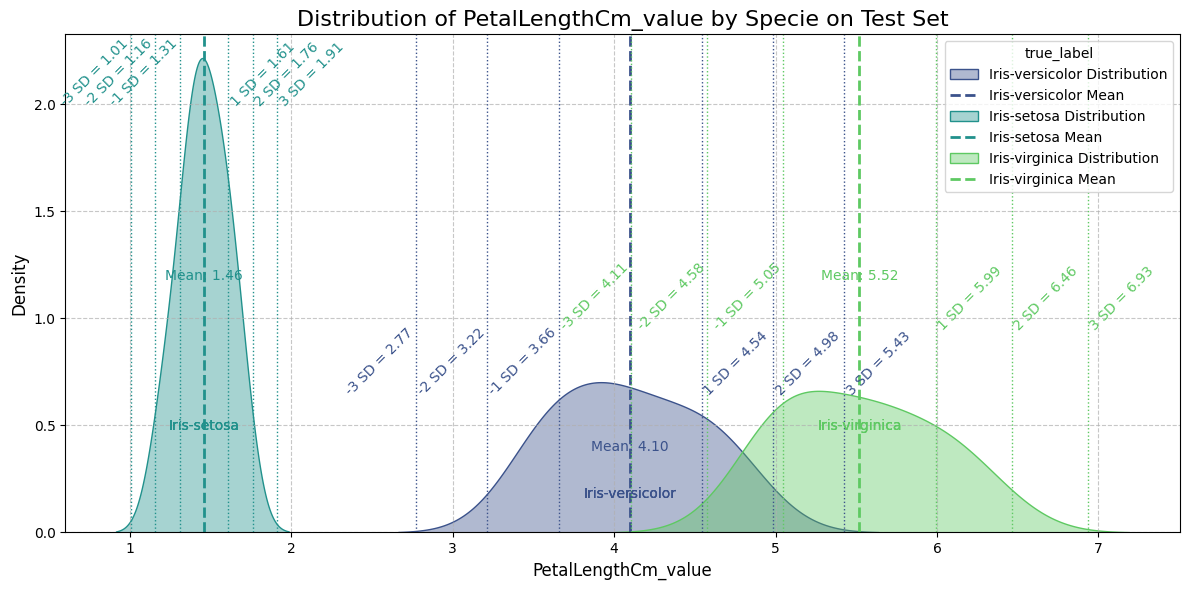

In [489]:
plot_distributions_of_feature_by_classes(
    general_df=general_test_df_for_plot,
    feature_name='PetalLengthCm_value',
    target_name='true_label',
    flag='test'
)

The distributions of the problematic feature on test set indicate that the root of the problem lies in the overlapping of the two distributions (Versicolor and Virginica), starting from approximately ±1.5 standard deviation.

Visualize distributions of problematic feature (PetalLengthCm) by classes for train set and visualize missclassifications 

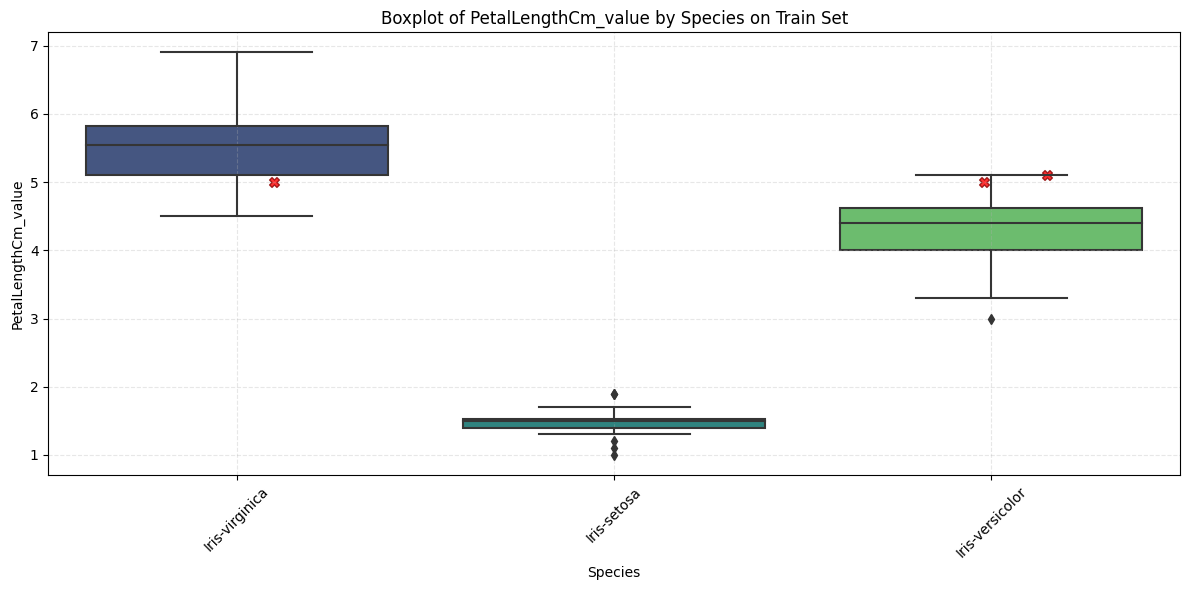

In [490]:
plot_boxplot_with_missclassifications(
    general_df=general_train_df_for_plot,
    feature_name='PetalLengthCm_value',
    target_name='true_label',
    flag='train'
)

As seen in the graph, all misclassifications occur in the region where the two distributions overlap. This is because the prediction probabilities for the classes at the intersection boundary (within ± 1 standard deviation) are approximately equal, resulting in similar probabilities for both classes. Further out, at the ends of the distributions, the probabilities for each class drop significantly, and in the central region, the separation is almost perfect.

This feature has the highest coefficient in the linear equation, making it the most influential for classification. However, due to the near 50% probabilities for both classes in this overlapping region, we observe misclassifications. Analyzing the class probabilities confirms that they are approximately equal (around 50%).


Visualize distributions of problematic feature (PetalLengthCm) by classes for test set and visualize missclassifications 

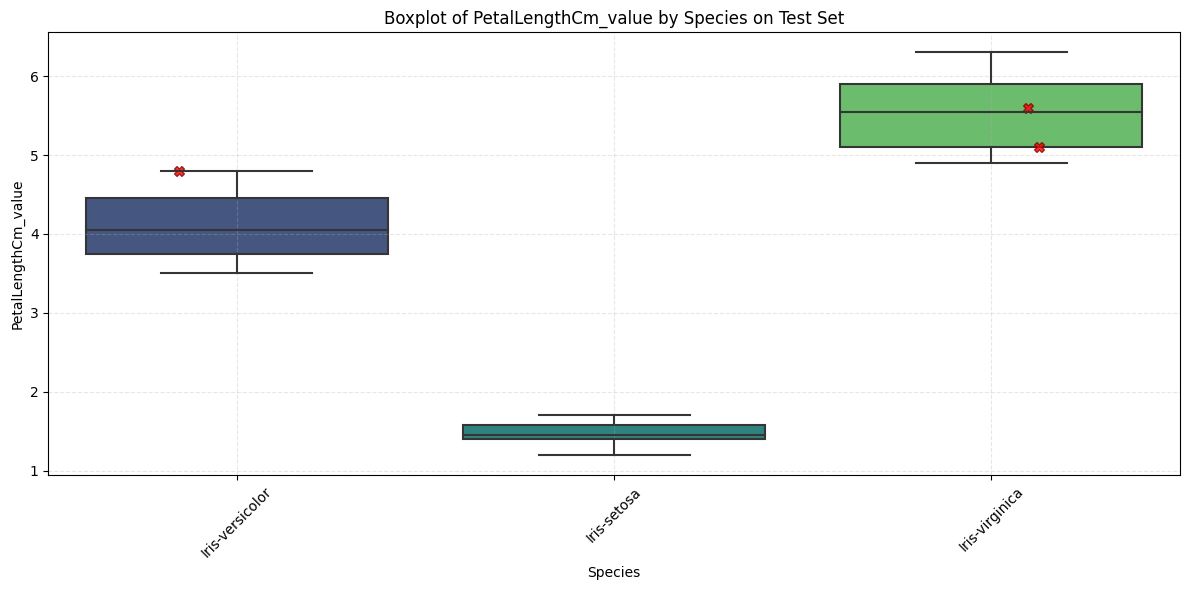

In [491]:
plot_boxplot_with_missclassifications(
    general_df=general_test_df_for_plot,
    feature_name='PetalLengthCm_value',
    target_name='true_label',
    flag='test'
)

### Feature Engineering

Since all the misclassifications occur under the highest influence of the **PetalLengthCm** feature, and this feature does not provide linear separability between the classes, it might be worth considering removing it from the dataset.

In [492]:
train_features_without_petallength = generated_train_measurements.drop(columns=['PetalLengthCm'])
test_features_without_petallength = generated_test_measurements.drop(columns=['PetalLengthCm'])

# 🧾 Display shapes of all relevant datasets
print("Shape of training labels:", generated_train_species_labels.shape)
print("Shape of training features (without 'PetalLengthCm'):", train_features_without_petallength.shape)

print("Shape of test features (without 'PetalLengthCm'):", test_features_without_petallength.shape)
print("Shape of test labels:", generated_test_species_labels.shape)

print(train_features_without_petallength.head())

Shape of training labels: (120,)
Shape of training features (without 'PetalLengthCm'): (120, 5)
Shape of test features (without 'PetalLengthCm'): (30, 5)
Shape of test labels: (30,)
     SepalLengthCm  SepalWidthCm  PetalWidthCm  PetalRatio  SepalRatio
123            6.3           2.7           1.8    2.722222    2.333333
106            4.9           2.5           1.7    2.647059    1.960000
149            5.9           3.0           1.8    2.833333    1.966667
10             5.4           3.7           0.2    7.500000    1.459459
98             5.1           2.5           1.1    2.727273    2.040000


Current working model is a logistic regression classifier with the following configuration:

- **Regularization**: L2 (Ridge), to penalize large coefficients and reduce overfitting.
- **Optimization algorithm**: LBFGS
- **Max iterations**: 50, to ensure convergence within a reasonable time frame.

In [493]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_for_logistic_regression(
    trial=trial,
    X_train=train_features_without_petallength,
    y_train=generated_train_species_labels,
    X_test=test_features_without_petallength,
    y_test=generated_test_species_labels
), n_trials=50)

best_params = study.best_params
print(f'Best Hyperparameters: {best_params}')

working_model_without_petallength = LogisticRegression(**best_params, random_state=41)
working_model_without_petallength.fit(train_features_without_petallength, generated_train_species_labels)

working_train_without_petallength_df_with_predictions, working_train_without_petallength_accuracy, working_train_without_petallength_precision, working_train_without_petallength_recall, working_train_without_petallength_f1 = evaluate_model(train_features_without_petallength, generated_train_species_labels, working_model_without_petallength)
working_test_without_petallength_df_with_predictions, working_test_without_petallength_accuracy, working_test_without_petallength_precision, working_test_without_petallength_recall, working_test_without_petallength_f1 = evaluate_model(test_features_without_petallength, generated_test_species_labels, working_model_without_petallength)

print("Working model evaluation (without 'PetalLengthCm'):")
print(f"Train Accuracy: {working_train_without_petallength_accuracy:.4f}")
print(f"Train Precision: {working_train_without_petallength_precision:.4f}")
print(f"Train Recall: {working_train_without_petallength_recall:.4f}")
print(f"Train F1: {working_train_without_petallength_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {working_test_without_petallength_accuracy:.4f}")
print(f"Test Precision: {working_test_without_petallength_precision:.4f}")
print(f"Test Recall: {working_test_without_petallength_recall:.4f}")
print(f"Test F1: {working_test_without_petallength_f1:.4f}")

[I 2025-07-17 13:07:45,921] A new study created in memory with name: no-name-21022a99-5c43-4084-b424-528e2c5507fc


/home/nikolay/Deloitte/project_task/Iris/src/core/helpers/optuna_objective.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-07-17 13:07:45,933] Trial 0 finished with value: 0.8997493734335839 and parameters: {'C': 1.8901366363607943, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 606, 'solver': 'saga'}. Best is trial 0 with value: 0.8997493734335839.
/home/nikolay/Deloitte/project_task/Iris/src/core/helpers/optuna_objective.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-07-17 13:07:45,937] Trial 1 finished with value: 0.8666666666666667 and param

Best Hyperparameters: {'C': 1.8901366363607943, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 606, 'solver': 'saga'}
Working model evaluation (without 'PetalLengthCm'):
Train Accuracy: 0.9750
Train Precision: 0.9752
Train Recall: 0.9750
Train F1: 0.9750
---------------------
Test Accuracy: 0.9000
Test Precision: 0.9024
Test Recall: 0.9000
Test F1: 0.8997


In [494]:
working_train_without_petallength_df_with_predictions.head()

,SepalLengthCm,SepalWidthCm,PetalWidthCm,PetalRatio,SepalRatio,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
123,6.3,2.7,1.8,2.722222,2.333333,2,2,0.001,0.198,0.802,True
106,4.9,2.5,1.7,2.647059,1.960000,2,2,0.011,0.386,0.603,True
149,5.9,3.0,1.8,2.833333,1.966667,2,2,0.007,0.345,0.647,True
10,5.4,3.7,0.2,7.500000,1.459459,0,0,0.999,0.001,0.000,True
98,5.1,2.5,1.1,2.727273,2.040000,1,1,0.033,0.875,0.092,True


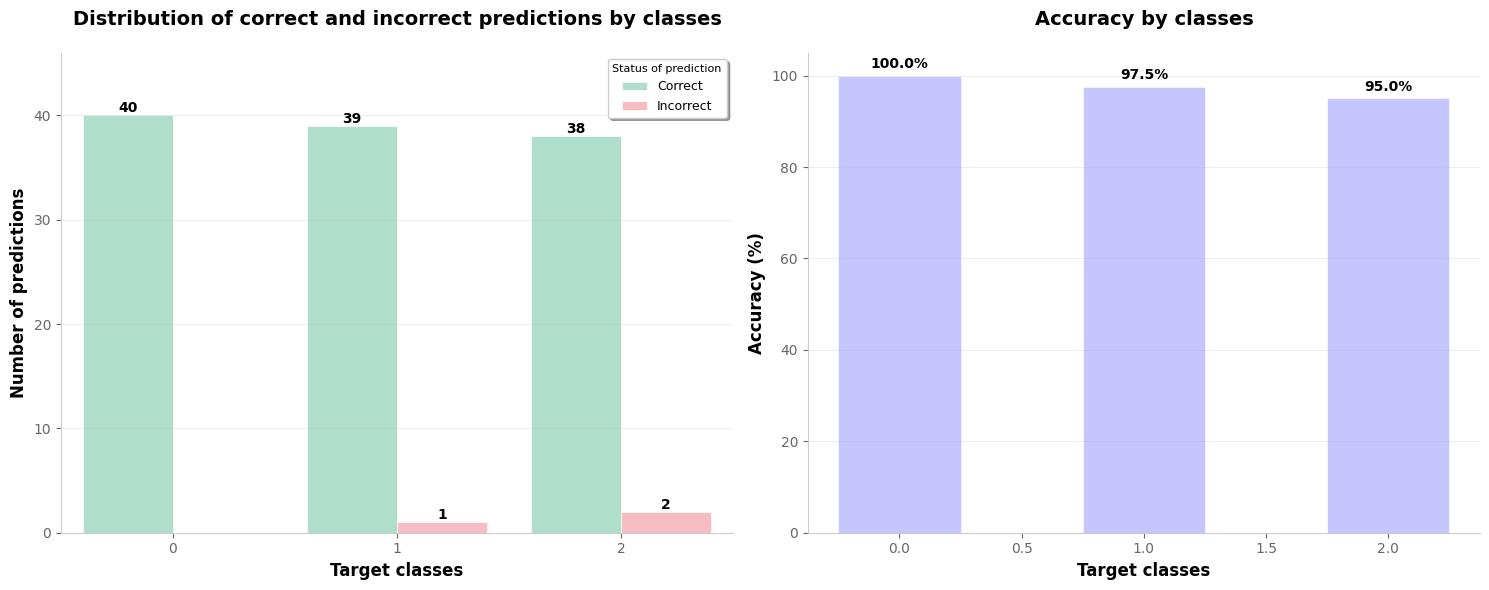

In [495]:
plot_error_distribution(working_train_without_petallength_df_with_predictions['predicted_label'], generated_train_species_labels)

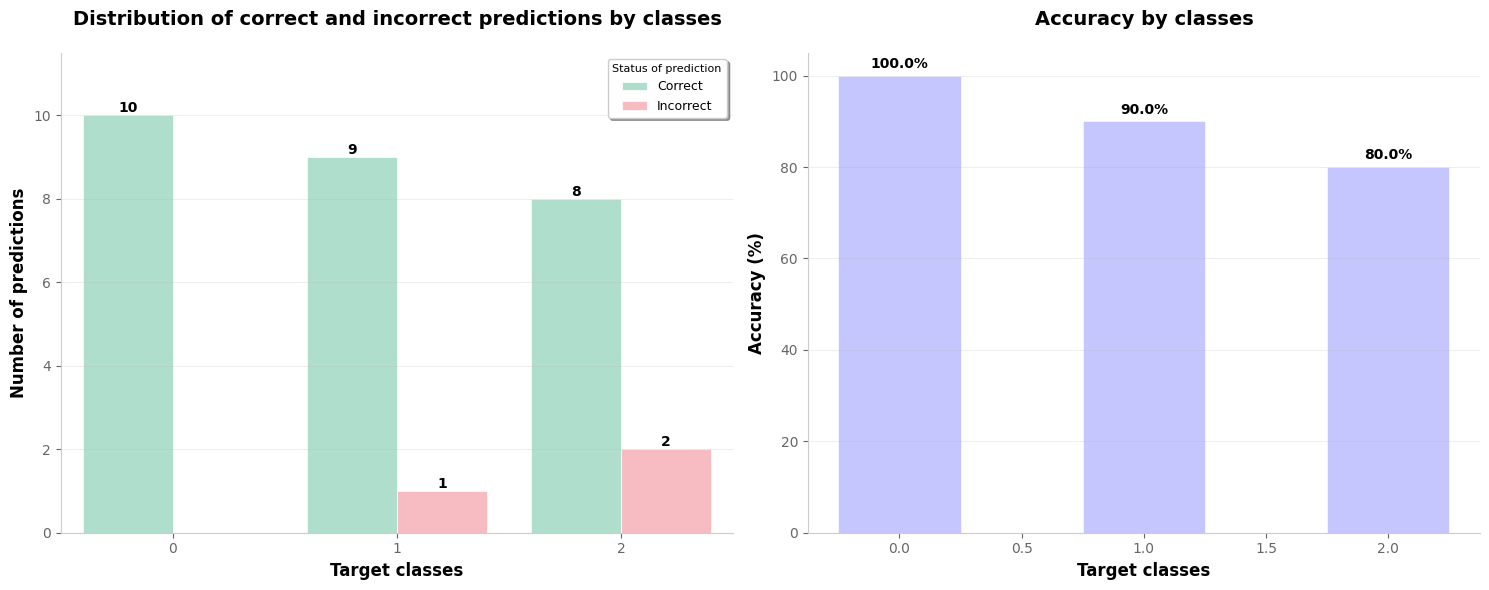

In [496]:
plot_error_distribution(working_test_without_petallength_df_with_predictions['predicted_label'], generated_test_species_labels)

In [497]:
working_train_df_without_petallength_errors = working_train_without_petallength_df_with_predictions[working_train_without_petallength_df_with_predictions['is_correct'] == False]
working_train_df_without_petallength_errors.iloc[:]

,SepalLengthCm,SepalWidthCm,PetalWidthCm,PetalRatio,SepalRatio,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
77,6.7,3.0,1.7,2.941176,2.233333,1,2,0.002,0.389,0.609,False
129,7.2,3.0,1.6,3.625000,2.400000,2,1,0.005,0.764,0.231,False
119,6.0,2.2,1.5,3.333333,2.727273,2,1,0.002,0.730,0.267,False


In [498]:
working_test_df_without_petallength_errors = working_test_without_petallength_df_with_predictions[working_test_without_petallength_df_with_predictions['is_correct'] == False]
working_test_df_without_petallength_errors.head()

,SepalLengthCm,SepalWidthCm,PetalWidthCm,PetalRatio,SepalRatio,true_label,predicted_label,probability_of_0,probability_of_1,probability_of_2,is_correct
134,6.1,2.6,1.4,4.000000,2.346154,2,1,0.030,0.933,0.037,False
70,5.9,3.2,1.8,2.666667,1.843750,1,2,0.009,0.305,0.686,False
133,6.3,2.8,1.5,3.400000,2.250000,2,1,0.013,0.809,0.178,False


In [499]:
working_weights_without_petallength = working_model_without_petallength.coef_
working_bias_without_petallength = working_model_without_petallength.intercept_
working_feature_names = train_features_without_petallength.columns.tolist()

print(f"Working\nWeights: {working_weights_without_petallength}\nBias: {working_bias_without_petallength}")

Working
Weights: [[-1.18035303  1.61314948 -2.11240829  1.71987615 -1.04805741]
 [ 0.26747975 -0.3170425  -1.14425928  0.24766924  0.55887871]
 [ 0.91287328 -1.29610698  3.25666757 -1.96754539  0.4891787 ]]
Bias: [ 0.32697622  0.71157488 -1.0385511 ]


In [500]:
working_train_detailed_df_without_petallength= create_detailed_analysis(working_train_df_without_petallength_errors, working_weights_without_petallength, working_bias_without_petallength, working_feature_names)
working_test_detailed_df_without_petallength = create_detailed_analysis(working_test_df_without_petallength_errors, working_weights_without_petallength, working_bias_without_petallength, working_feature_names)
working_train_detailed_df_without_petallength.head()

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,PetalRatio_value,PetalRatio_contribution_class_0,PetalRatio_weight_class_0,PetalRatio_contribution_class_1,PetalRatio_weight_class_1,PetalRatio_contribution_class_2,PetalRatio_weight_class_2,SepalRatio_value,SepalRatio_contribution_class_0,SepalRatio_weight_class_0,SepalRatio_contribution_class_1,SepalRatio_weight_class_1,SepalRatio_contribution_class_2,SepalRatio_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalWidthCm,contribution_diff_PetalRatio,contribution_diff_SepalRatio,bias_diff
0,77,1,2,-3.615,0.002,0.327,1.584,0.389,0.712,2.031,0.609,-1.039,6.7,-7.908,-1.18,1.792,0.267,6.116,0.913,3.0,4.839,1.613,-0.951,-0.317,-3.888,-1.296,1.7,-3.591,-2.112,-1.945,-1.144,5.536,3.257,2.941,5.058,1.72,0.728,0.248,-5.787,-1.968,2.233,-2.341,-1.048,1.248,0.559,1.092,0.489,4.324,-2.937,7.482,-6.515,-0.156,-1.75
1,129,2,1,-2.993,0.005,0.327,2.095,0.764,0.712,0.898,0.231,-1.039,7.2,-8.499,-1.18,1.926,0.267,6.573,0.913,3.0,4.839,1.613,-0.951,-0.317,-3.888,-1.296,1.6,-3.380,-2.112,-1.831,-1.144,5.211,3.257,3.625,6.235,1.72,0.898,0.248,-7.132,-1.968,2.400,-2.515,-1.048,1.341,0.559,1.174,0.489,-4.647,2.937,-7.041,8.030,0.167,1.75
2,119,2,1,-3.500,0.002,0.327,2.252,0.730,0.712,1.248,0.267,-1.039,6.0,-7.082,-1.18,1.605,0.267,5.477,0.913,2.2,3.549,1.613,-0.697,-0.317,-2.851,-1.296,1.5,-3.169,-2.112,-1.716,-1.144,4.885,3.257,3.333,5.733,1.72,0.826,0.248,-6.558,-1.968,2.727,-2.858,-1.048,1.524,0.559,1.334,0.489,-3.872,2.154,-6.601,7.384,0.190,1.75


In [501]:
working_train_error_df_without_petallength = working_train_detailed_df_without_petallength[working_train_detailed_df_without_petallength['true_label'] != working_train_detailed_df_without_petallength['predicted_label']]
print(list(working_train_error_df_without_petallength.columns))
print(working_train_error_df_without_petallength.shape)
working_train_error_df_without_petallength.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 'PetalWidthCm_contribution_class_1', 'PetalWidthCm_weight_class_1', 'PetalWidthCm_contribution_class_2', 'PetalWidthCm_weight_class_2', 'PetalRatio_value', 'PetalRatio_contribution_class_0', 'PetalRatio_weight_class_0', 'PetalRatio_c

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,PetalRatio_value,PetalRatio_contribution_class_0,PetalRatio_weight_class_0,PetalRatio_contribution_class_1,PetalRatio_weight_class_1,PetalRatio_contribution_class_2,PetalRatio_weight_class_2,SepalRatio_value,SepalRatio_contribution_class_0,SepalRatio_weight_class_0,SepalRatio_contribution_class_1,SepalRatio_weight_class_1,SepalRatio_contribution_class_2,SepalRatio_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalWidthCm,contribution_diff_PetalRatio,contribution_diff_SepalRatio,bias_diff
0,77,1,2,-3.615,0.002,0.327,1.584,0.389,0.712,2.031,0.609,-1.039,6.7,-7.908,-1.18,1.792,0.267,6.116,0.913,3.0,4.839,1.613,-0.951,-0.317,-3.888,-1.296,1.7,-3.591,-2.112,-1.945,-1.144,5.536,3.257,2.941,5.058,1.72,0.728,0.248,-5.787,-1.968,2.233,-2.341,-1.048,1.248,0.559,1.092,0.489,4.324,-2.937,7.482,-6.515,-0.156,-1.75
1,129,2,1,-2.993,0.005,0.327,2.095,0.764,0.712,0.898,0.231,-1.039,7.2,-8.499,-1.18,1.926,0.267,6.573,0.913,3.0,4.839,1.613,-0.951,-0.317,-3.888,-1.296,1.6,-3.380,-2.112,-1.831,-1.144,5.211,3.257,3.625,6.235,1.72,0.898,0.248,-7.132,-1.968,2.400,-2.515,-1.048,1.341,0.559,1.174,0.489,-4.647,2.937,-7.041,8.030,0.167,1.75
2,119,2,1,-3.500,0.002,0.327,2.252,0.730,0.712,1.248,0.267,-1.039,6.0,-7.082,-1.18,1.605,0.267,5.477,0.913,2.2,3.549,1.613,-0.697,-0.317,-2.851,-1.296,1.5,-3.169,-2.112,-1.716,-1.144,4.885,3.257,3.333,5.733,1.72,0.826,0.248,-6.558,-1.968,2.727,-2.858,-1.048,1.524,0.559,1.334,0.489,-3.872,2.154,-6.601,7.384,0.190,1.75


In [502]:
working_test_error_df_without_petallength = working_test_detailed_df_without_petallength[working_test_detailed_df_without_petallength['true_label'] != working_test_detailed_df_without_petallength['predicted_label']]
print(list(working_test_error_df_without_petallength.columns))
print(working_test_error_df_without_petallength.shape)
working_test_error_df_without_petallength.head()

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 'PetalWidthCm_contribution_class_1', 'PetalWidthCm_weight_class_1', 'PetalWidthCm_contribution_class_2', 'PetalWidthCm_weight_class_2', 'PetalRatio_value', 'PetalRatio_contribution_class_0', 'PetalRatio_weight_class_0', 'PetalRatio_c

,original_idx,true_label,predicted_label,logit_class_0,probability_class_0,bias_class_0,logit_class_1,probability_class_1,bias_class_1,logit_class_2,probability_class_2,bias_class_2,SepalLengthCm_value,SepalLengthCm_contribution_class_0,SepalLengthCm_weight_class_0,SepalLengthCm_contribution_class_1,SepalLengthCm_weight_class_1,SepalLengthCm_contribution_class_2,SepalLengthCm_weight_class_2,SepalWidthCm_value,SepalWidthCm_contribution_class_0,SepalWidthCm_weight_class_0,SepalWidthCm_contribution_class_1,SepalWidthCm_weight_class_1,SepalWidthCm_contribution_class_2,SepalWidthCm_weight_class_2,PetalWidthCm_value,PetalWidthCm_contribution_class_0,PetalWidthCm_weight_class_0,PetalWidthCm_contribution_class_1,PetalWidthCm_weight_class_1,PetalWidthCm_contribution_class_2,PetalWidthCm_weight_class_2,PetalRatio_value,PetalRatio_contribution_class_0,PetalRatio_weight_class_0,PetalRatio_contribution_class_1,PetalRatio_weight_class_1,PetalRatio_contribution_class_2,PetalRatio_weight_class_2,SepalRatio_value,SepalRatio_contribution_class_0,SepalRatio_weight_class_0,SepalRatio_contribution_class_1,SepalRatio_weight_class_1,SepalRatio_contribution_class_2,SepalRatio_weight_class_2,contribution_diff_SepalLengthCm,contribution_diff_SepalWidthCm,contribution_diff_PetalWidthCm,contribution_diff_PetalRatio,contribution_diff_SepalRatio,bias_diff
0,134,2,1,-1.216,0.030,0.327,2.219,0.933,0.712,-1.003,0.037,-1.039,6.1,-7.200,-1.18,1.632,0.267,5.569,0.913,2.6,4.194,1.613,-0.824,-0.317,-3.370,-1.296,1.4,-2.957,-2.112,-1.602,-1.144,4.559,3.257,4.000,6.880,1.72,0.991,0.248,-7.870,-1.968,2.346,-2.459,-1.048,1.311,0.559,1.148,0.489,-3.937,2.546,-6.161,8.861,0.164,1.75
1,70,1,2,-2.623,0.009,0.327,0.906,0.305,0.712,1.717,0.686,-1.039,5.9,-6.964,-1.18,1.578,0.267,5.386,0.913,3.2,5.162,1.613,-1.015,-0.317,-4.148,-1.296,1.8,-3.802,-2.112,-2.060,-1.144,5.862,3.257,2.667,4.586,1.72,0.660,0.248,-5.247,-1.968,1.844,-1.932,-1.048,1.030,0.559,0.902,0.489,3.808,-3.133,7.922,-5.907,-0.129,-1.75
2,133,2,1,-2.272,0.013,0.327,1.892,0.809,0.712,0.379,0.178,-1.039,6.3,-7.436,-1.18,1.685,0.267,5.751,0.913,2.8,4.517,1.613,-0.888,-0.317,-3.629,-1.296,1.5,-3.169,-2.112,-1.716,-1.144,4.885,3.257,3.400,5.848,1.72,0.842,0.248,-6.690,-1.968,2.250,-2.358,-1.048,1.257,0.559,1.101,0.489,-4.066,2.741,-6.601,7.532,0.157,1.75


In [503]:
results = analyze_classification_errors_simple(
    df=working_train_error_df_without_petallength,
    feature_names=train_features_without_petallength.columns.tolist()
)

Analyse classification errors
Number of errors: 3

ERROR #1 (ID: 77.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalWidthCm   : value=1.70, contribution=7.482 
  PetalRatio     : value=2.94, contribution=-6.515 
  SepalLengthCm  : value=6.70, contribution=4.324 
  SepalWidthCm   : value=3.00, contribution=-2.937 
  SepalRatio     : value=2.23, contribution=-0.156 
Main impact: PetalWidthCm (contribution: 7.482)

ERROR #2 (ID: 129.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalRatio     : value=3.62, contribution=8.030 
  PetalWidthCm   : value=1.60, contribution=-7.041 
  SepalLengthCm  : value=7.20, contribution=-4.647 
  SepalWidthCm   : value=3.00, contribution=2.937 
  SepalRatio     : value=2.40, contribution=0.167 
Main impact: PetalRatio (contribution: 8.030)

ERROR #3 (ID: 119.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalRatio     : value=3.33, contributio

In [504]:
results = analyze_classification_errors_simple(
    df=working_test_error_df_without_petallength,
    feature_names=test_features_without_petallength.columns.tolist()
)

Analyse classification errors
Number of errors: 3

ERROR #1 (ID: 134.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalRatio     : value=4.00, contribution=8.861 
  PetalWidthCm   : value=1.40, contribution=-6.161 
  SepalLengthCm  : value=6.10, contribution=-3.937 
  SepalWidthCm   : value=2.60, contribution=2.546 
  SepalRatio     : value=2.35, contribution=0.164 
Main impact: PetalRatio (contribution: 8.861)

ERROR #2 (ID: 70.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalWidthCm   : value=1.80, contribution=7.922 
  PetalRatio     : value=2.67, contribution=-5.907 
  SepalLengthCm  : value=5.90, contribution=3.808 
  SepalWidthCm   : value=3.20, contribution=-3.133 
  SepalRatio     : value=1.84, contribution=-0.129 
Main impact: PetalWidthCm (contribution: 7.922)

ERROR #3 (ID: 133.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalRatio     : value=3.40, contributio